In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import holidays
from datetime import datetime
import re
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

# Data cleaning, imputation, and encoding


**Authors:** Tobias Schulze, Tiago Russomano, Johanna Stärkl

**Last update:** 16 October 2023

All imported files were preprocessed to standardize file name schemes and separators.

In general, issues occurring during import and data type conversion was fixed on the fly.

Further curation will be performed after in deep evaluation of the data.

## Goals of this notebook

In [2]:
df = pd.read_csv('./data/231018_merged_tables_basic_data.csv', low_memory=False, header = 0, index_col=0, na_values='n/a')

In [3]:
# store date in string format
df['date'] = df.apply(lambda row: datetime(row['an'], row['mois'], row['jour']).strftime('%Y-%m-%d'), axis = 1)
df.head()

,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,...,env1,senc,catv,occutc,obs,obsm,choc,manv,motor,date
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,138306524.0,B01,2.0,2,4,2,2002.0,0.0,1.0,0.0,...,NaN,2.0,7,NaN,0.0,2.0,5.0,23.0,1.0,2019-11-30
201900000001,138306524.0,B01,1.0,1,4,2,1993.0,5.0,1.0,0.0,...,NaN,2.0,7,NaN,0.0,2.0,5.0,23.0,1.0,2019-11-30
201900000001,138306525.0,A01,1.0,1,1,1,1959.0,0.0,1.0,0.0,...,NaN,2.0,17,NaN,1.0,0.0,3.0,11.0,1.0,2019-11-30
201900000002,138306523.0,A01,1.0,1,4,2,1994.0,0.0,1.0,0.0,...,NaN,1.0,7,NaN,4.0,0.0,1.0,0.0,1.0,2019-11-30
201900000003,138306520.0,A01,1.0,1,1,1,1996.0,0.0,1.0,0.0,...,NaN,1.0,7,NaN,0.0,2.0,1.0,2.0,1.0,2019-11-28


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509598 entries, 201900000001 to 201800057783
Data columns (total 58 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id_vehicule   float64
 1   num_veh       object 
 2   place         float64
 3   catu          int64  
 4   grav          int64  
 5   sexe          int64  
 6   an_nais       float64
 7   trajet        float64
 8   secu1         float64
 9   secu2         float64
 10  secu3         float64
 11  locp          float64
 12  actp          object 
 13  etatp         float64
 14  secu          float64
 15  an            int64  
 16  mois          int64  
 17  jour          int64  
 18  hrmn          object 
 19  lum           int64  
 20  agg           int64  
 21  int           int64  
 22  atm           float64
 23  col           float64
 24  com           object 
 25  adr           object 
 26  gps           object 
 27  lat           float64
 28  long          float64
 29  dep           int64  
 30  metropo

In [5]:
# Drop 

In [6]:
# get holiday list for France
fr_holidays = holidays.FR()
df['is_holiday'] = df.apply(lambda row: row['date'] in fr_holidays, axis = 1)
df['holiday'] = df.apply(lambda row: fr_holidays.get(row['date']) if row['is_holiday'] == True else np.nan, axis = 1)
df.head()

,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,...,catv,occutc,obs,obsm,choc,manv,motor,date,is_holiday,holiday
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,138306524.0,B01,2.0,2,4,2,2002.0,0.0,1.0,0.0,...,7,NaN,0.0,2.0,5.0,23.0,1.0,2019-11-30,False,NaN
201900000001,138306524.0,B01,1.0,1,4,2,1993.0,5.0,1.0,0.0,...,7,NaN,0.0,2.0,5.0,23.0,1.0,2019-11-30,False,NaN
201900000001,138306525.0,A01,1.0,1,1,1,1959.0,0.0,1.0,0.0,...,17,NaN,1.0,0.0,3.0,11.0,1.0,2019-11-30,False,NaN
201900000002,138306523.0,A01,1.0,1,4,2,1994.0,0.0,1.0,0.0,...,7,NaN,4.0,0.0,1.0,0.0,1.0,2019-11-30,False,NaN
201900000003,138306520.0,A01,1.0,1,1,1,1996.0,0.0,1.0,0.0,...,7,NaN,0.0,2.0,1.0,2.0,1.0,2019-11-28,False,NaN


In [7]:
df['holiday'].unique()

array([nan, 'Ascension Day', 'Victory Day', 'Labor Day', 'Assumption Day',
       'Whit Monday', "New Year's Day", 'Easter Monday', 'Christmas Day',
       'Armistice Day', 'National Day', "All Saints' Day",
       'Ascension Day; Labor Day'], dtype=object)

In [8]:
#calculate missing values of each colum
percent_missing = round(df.isnull().sum() * 100 / len(df), 1)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
percent_missing

id_vehicule     85.4
num_veh          0.0
place            4.9
catu             0.0
grav             0.0
sexe             0.0
an_nais          0.2
trajet           0.0
secu1           85.4
secu2           85.4
secu3           85.4
locp             2.2
actp             2.2
etatp            2.2
secu            16.9
an               0.0
mois             0.0
jour             0.0
hrmn             0.0
lum              0.0
agg              0.0
int              0.0
atm              0.0
col              0.0
com              0.0
adr             13.7
gps             56.3
lat             42.5
long            42.8
dep              0.0
metropolitan     0.0
catr             0.0
voie             9.0
v1              56.4
v2              95.2
circ             0.1
nbv              0.2
vosp             0.3
prof             0.2
pr              40.7
pr1             40.8
plan             0.2
lartpc          19.7
larrout         10.2
surf             0.2
infra            0.5
situ             0.5
vma          

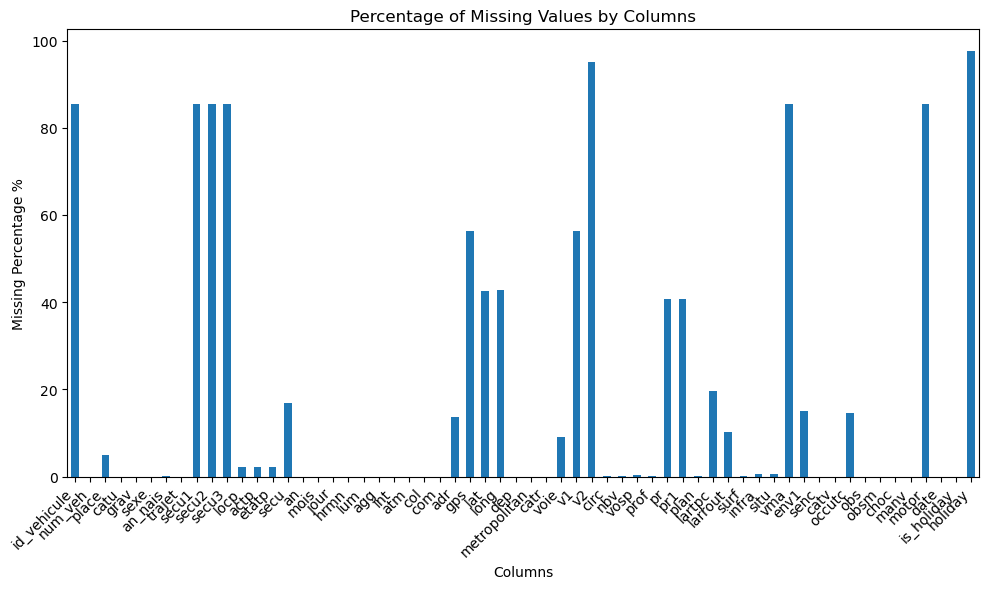

In [9]:
# bar plot of the missing percentages values of each colum
plt.figure(figsize=(10, 6))
percent_missing.plot(kind='bar')
plt.title('Percentage of Missing Values by Columns')
plt.xlabel('Columns')
plt.ylabel('Missing Percentage %')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
#cleaning of the dataset regarding missing values

#delete columns id_vehicule, com, gps, voie, v1, v2, pr, pr1, lartpc, larrout, vma, env1, motor, secu1, 
#secu2, secu3, secu

df.drop(['id_vehicule', 'com', 'gps', 'voie', 'v1', 'v2',
         'pr', 'pr1', 'lartpc', 'larrout', 'vma', 'env1', 'motor', 
         'secu', 'secu1', 'secu2', 'secu3'], axis=1, inplace=True)


In [11]:
#replace NaN with -1 (coded as no information) in columns
#place, an_nais, trajet, locp, actp, etatp ,atm, col, circ, nbv, vosp, prof, plan, surf, infra
#situ, senc, occutc, obs, obsm, choc, manv

df.fillna({'place':-1, 'an_nais':-1, 'trajet':-1, 'locp':-1, 'actp': -1,
           'etatp':-1, 'atm':-1, 'col':-1, 'circ':-1, 
           'nbv':-1, 'vosp':-1, 'prof':-1, 'plan': -1, 
           'surf':-1, 'infra':-1, 'situ': -1, 'senc':-1, 'occutc':-1, 
           'obs': -1, 'obsm': -1, 'choc':-1, 'manv':-1}, inplace=True)

In [12]:
#remove lines with NaN in column catr

df.dropna(subset=['catr'], inplace=True)


In [13]:
#transform date to datetime
df['date'] =  pd.to_datetime(df['date'], format="%Y-%m-%d")

df['date'] = df['date'].dt.date

df['date'].describe()

count        2509596
unique          6209
top       2005-12-16
freq             832
Name: date, dtype: object

In [14]:
percent_missing_clean = round(df.isnull().sum() * 100 / len(df), 1)
percent_missing_clean

num_veh          0.0
place            0.0
catu             0.0
grav             0.0
sexe             0.0
an_nais          0.0
trajet           0.0
locp             0.0
actp             0.0
etatp            0.0
an               0.0
mois             0.0
jour             0.0
hrmn             0.0
lum              0.0
agg              0.0
int              0.0
atm              0.0
col              0.0
adr             13.7
lat             42.5
long            42.8
dep              0.0
metropolitan     0.0
catr             0.0
circ             0.0
nbv              0.0
vosp             0.0
prof             0.0
plan             0.0
surf             0.0
infra            0.0
situ             0.0
senc             0.0
catv             0.0
occutc           0.0
obs              0.0
obsm             0.0
choc             0.0
manv             0.0
date             0.0
is_holiday       0.0
holiday         97.7
dtype: float64

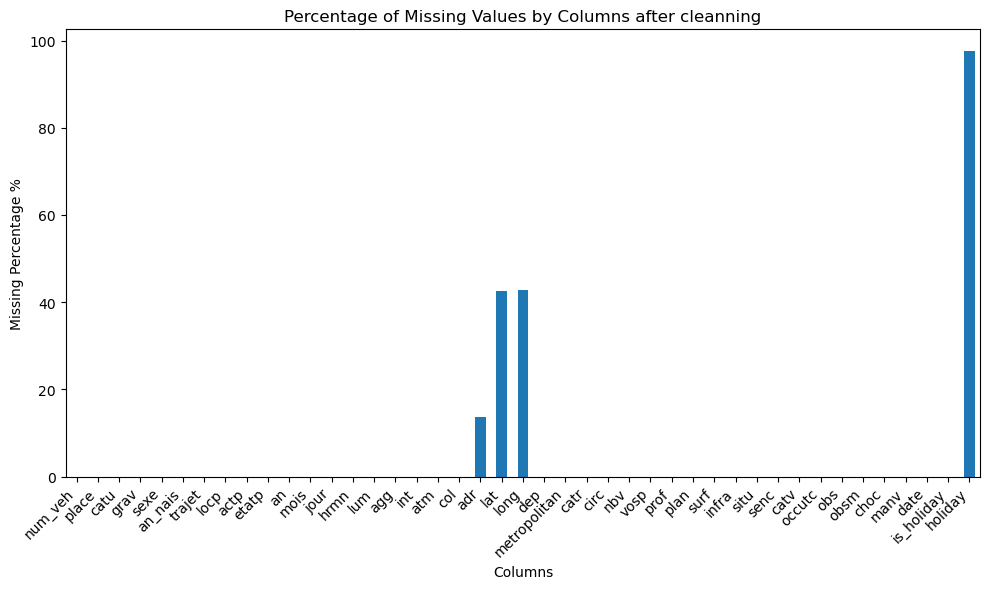

In [15]:
# bar plot of the missing percentages values of each colum
plt.figure(figsize=(10, 6))
percent_missing_clean.plot(kind='bar')
plt.title('Percentage of Missing Values by Columns after cleanning')
plt.xlabel('Columns')
plt.ylabel('Missing Percentage %')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Transform data types
### Date and time variables
The date and time variables are maybe important as grouping variables or as contrains for time dependent severity of accidents.

For the grouping, a timestamp is required for unbiased identification time related accidents.

_Problem_:

During the transformation of the `hrmn` variable, I got aware, that the string contain integers like `1`,  `801`, or `1300`. Hence, anytime during data conversion, the colon got lost and the values got truncated. Hence `1` should be `00:01` and so on. Therefore, we need an additional transformation of the truncated data to `hh:mm` format.

**Steps:**
1. Fixing the truncated values in `hrmn`

~~3. Creation of a `datatime` variable in format y-m-d hh:mm~~

~~4. Transformation of the datatime varible to a `timestamp` variable~~


In addition, we need to transform the type of `an_nais` to integer and `date` to `date`.

In [16]:
# Fixing the hrmn issue:
# Remove the colon
df['hrmn'] = df.apply(lambda x: re.sub(string=x['hrmn'], pattern=':', repl=''), axis = 1)

# Pad the string to four zeros
df['hrmn'] = df.apply(lambda x: x['hrmn'].zfill(4), axis = 1)

# Transform the variable to 'hh:mm' and split to hours and minutes
df = df.assign(hrmn = pd.to_datetime(df['hrmn'], format='%H%M').dt.strftime('%H:%M'))

# Create the daytime variable
df['datetime'] = df.apply(lambda x: datetime(x['an'], x['mois'], x['jour'], datetime.strptime(x['hrmn'], "%H:%M").hour, datetime.strptime(x['hrmn'], "%H:%M").minute), axis = 1)

# Create the timestamp
#df['timestamp'] = df.apply(lambda x: datetime.timestamp(x['datetime']), axis = 1)

# Transform `an_nais`
df['an_nais'] = df['an_nais'].astype('int64')


### this is not working 
# Transform `date`
#df = df.assign(date = pd.to_datetime(df['date'], format='mixed'))


In [17]:
df.hrmn

Num_Acc
201900000001    01:30
201900000001    01:30
201900000001    01:30
201900000002    02:50
201900000003    15:15
                ...  
201800057781    21:50
201800057782    19:45
201800057782    19:45
201800057783    14:25
201800057783    14:25
Name: hrmn, Length: 2509596, dtype: object

## Exploring the data before filtering the target region and target variable



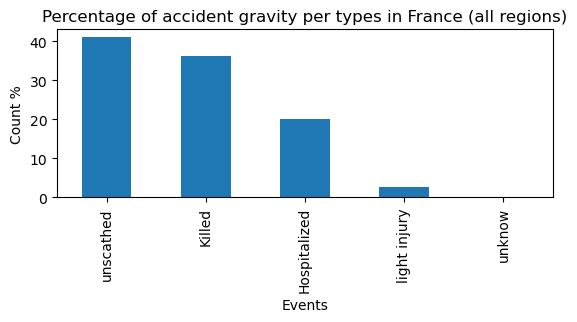

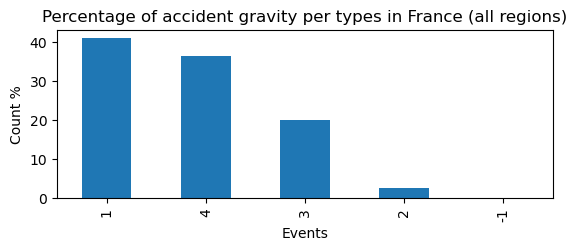

In [18]:
# exploring the types of accidents in France all regions
event_counts = df['grav'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(2,1,1)
event_percentages.plot.bar()
labels = ['unscathed','Killed','Hospitalized','light injury','unknow']
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Percentage of accident gravity per types in France (all regions)')
# Display the plot
plt.show()


# exploring the types of accidents in France all regions
event_counts = df['grav'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(2,1,1)
event_percentages.plot.bar()
#labels = ['unscathed','Killed','Hospitalized','light injury','unknow']
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)))#, labels)
plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Percentage of accident gravity per types in France (all regions)')
# Display the plot
plt.show()

In [19]:
df.grav.unique()

array([ 4,  1,  3,  2, -1])

/tmp/ipykernel_145241/2862478532.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='an', data=df[df['grav'] == 4], palette='viridis')


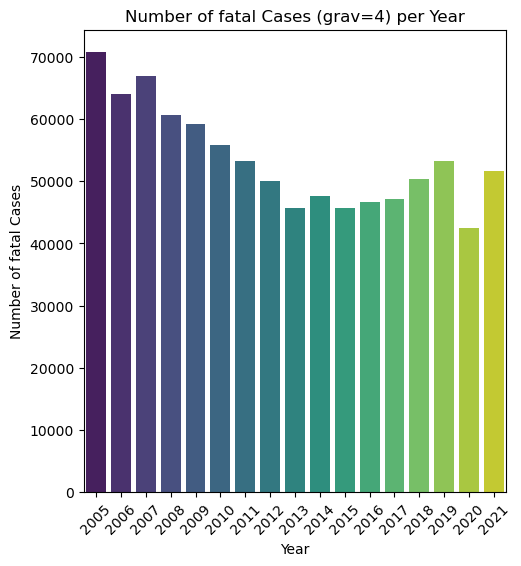

In [20]:
# explroring the number of acidents with fatal victims 

plt.figure(figsize=(12, 6))

# Plot for Severe Cases
plt.subplot(1, 2, 1)
sns.countplot(x='an', data=df[df['grav'] == 4], palette='viridis')
plt.xlabel('Year')
plt.ylabel('Number of fatal Cases')
plt.title('Number of fatal Cases (grav=4) per Year')
plt.xticks(rotation=45)


plt.show()

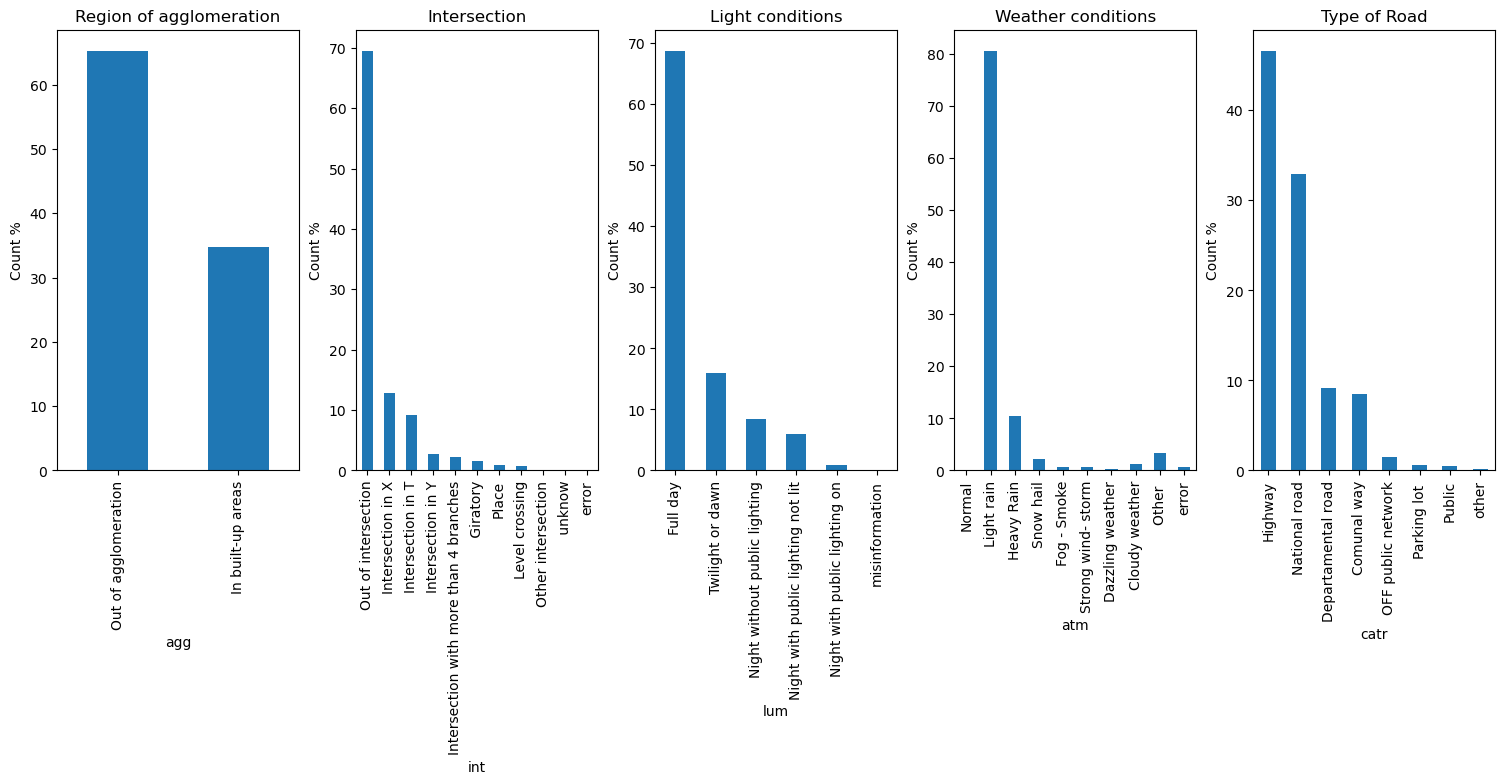

In [21]:
# exploring variables that might contribute to the accidents 
plt.figure(figsize=(15, 5))

#agglomeration
event_counts = df['agg'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(1, 5, 1)
plt.tight_layout(w_pad=3.0)
event_percentages.plot.bar()
labels = ['Out of agglomeration', 'In built-up areas']
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Region of agglomeration')

# light conditions for the accidents
event_counts = df['lum'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(1, 5, 3)
event_percentages.plot.bar()
labels = ['Full day', 'Twilight or dawn', 'Night without public lighting', 'Night with public lighting not lit', 'Night with public lighting on','misinformation']
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Light conditions')

# place of accident
event_counts = df['int'].value_counts()
labels = ['Out of intersection', 'Intersection in X', 'Intersection in T', 'Intersection in Y', 'Intersection with more than 4 branches',
        ' Giratory','Place' , 'Level crossing','Other intersection',' unknow', 'error']

# Add labels and title to the plot
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(1, 5, 2)
event_percentages.plot.bar()
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Intersection')


# weather conditions
event_counts = df['atm'].value_counts().sort_index()
labels = ['Normal', 'Light rain', 'Heavy Rain', 'Snow hail', 'Fog - Smoke','Strong wind- storm','Dazzling weather' , 'Cloudy weather',
          'Other ', 'error']

event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(1, 5, 4)
event_percentages.plot.bar()
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Weather conditions')

# type of road 
event_counts = df['catr'].value_counts()

# Plot the event counts
plt.subplot(1, 5, 5)
labels = ['Highway', 'National road', 'Departamental road', 'Comunal way', 'OFF public network','Parking lot ', 'Public','other']

event_percentages = (event_counts / event_counts.sum()) * 100
event_percentages.plot.bar()
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Type of Road')




#plt.subplots_adjust(wspace=0.5, hspace=1.5)
# Display the plot
plt.show()

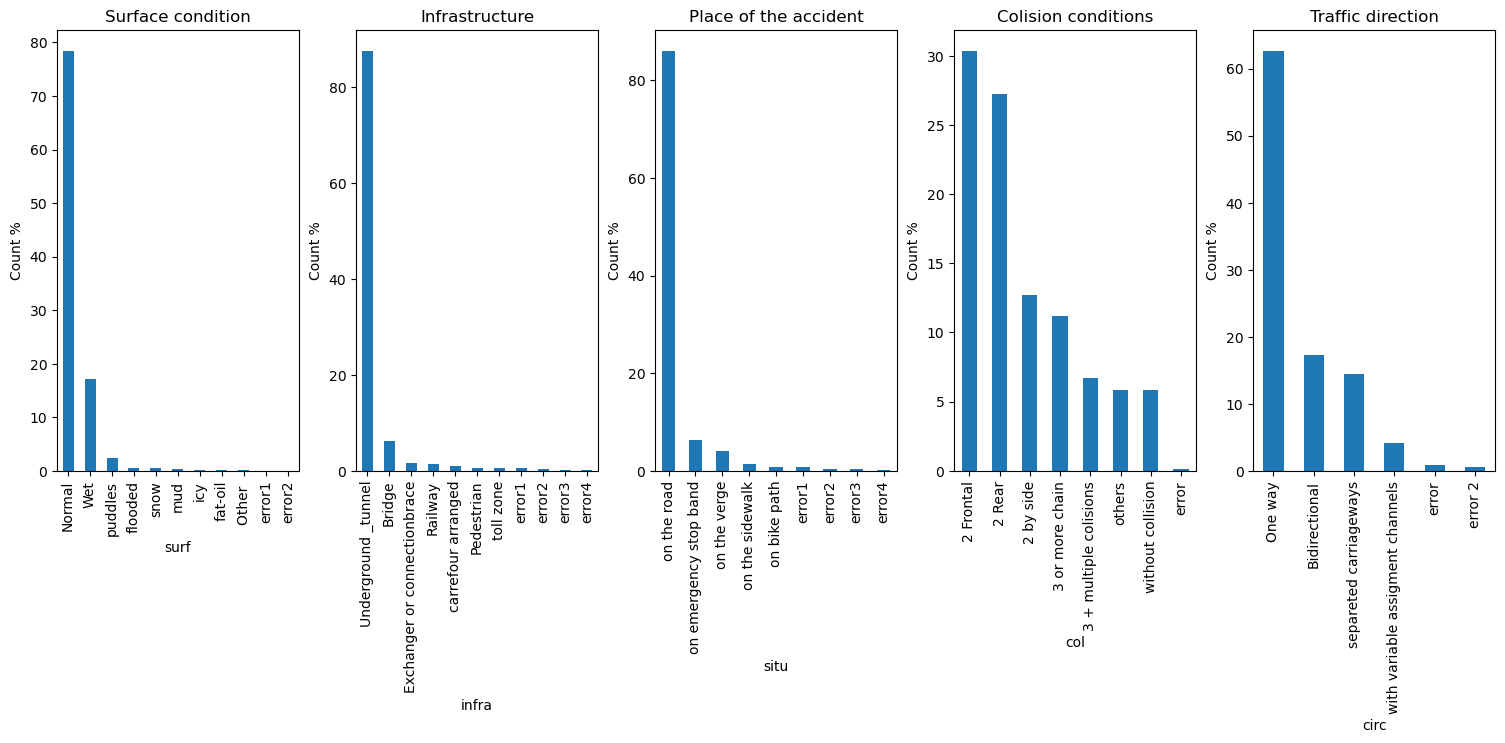

In [22]:
plt.figure(figsize=(15, 5))

# surface conditions
event_counts = df['surf'].value_counts()

# Plot the event counts
plt.subplot(1, 5, 1)
plt.tight_layout(w_pad=3.0)
labels = ['Normal', 'Wet', 'puddles', 'flooded', 'snow','mud','icy', 'fat-oil', 'Other ', 'error1','error2']
# Add labels and title to the plot
event_percentages = (event_counts / event_counts.sum()) * 100
event_percentages.plot.bar()
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Surface condition')

# infrastrucutre
event_counts = df['infra'].value_counts()

# Plot the event counts
plt.subplot(1, 5, 2)
labels = ['Underground _tunnel', 'Bridge', 'Exchanger or connectionbrace', 'Railway', 'carrefour arranged','Pedestrian','toll zone', 'error1','error2', 'error3','error4']
# Add labels and title to the plot
event_percentages = (event_counts / event_counts.sum()) * 100
event_percentages.plot.bar()
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Infrastructure')

# plce of accident 
event_counts = df['situ'].value_counts()

# Plot the event counts
plt.subplot(1, 5, 3)
labels = ['on the road', 'on emergency stop band', 'on the verge', 'on the sidewalk', 'on bike path', 'error1','error2', 'error3','error4']
event_percentages = (event_counts / event_counts.sum()) * 100
event_percentages.plot.bar()
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Place of the accident')

# colisiion conditions
event_counts = df['col'].value_counts()

# Plot the event counts
plt.subplot(1, 5, 4)
labels = ['2 Frontal', '2 Rear', '2 by side', '3 or more chain', '3 + multiple colisions','others', 'without collision','error']
event_percentages = (event_counts / event_counts.sum()) * 100
event_percentages.plot.bar()
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Colision conditions')

# direction of the accident 
event_counts = df['circ'].value_counts()

# Plot the event counts
plt.subplot(1, 5, 5)
labels = ['One way', 'Bidirectional', 'separeted carriageways', 'with variable assigment channels', 'error','error 2']
# Add labels and title to the plot
event_percentages = (event_counts / event_counts.sum()) * 100
event_percentages.plot.bar()
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Traffic direction')

# plot show
plt.show()

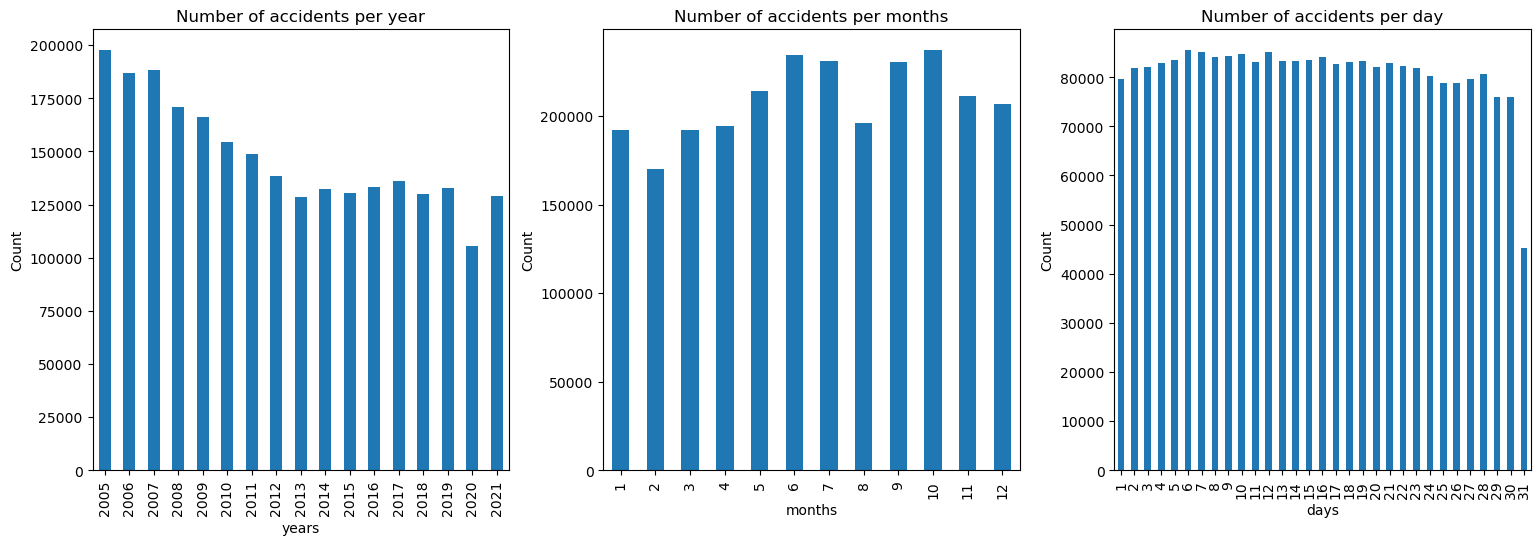

In [23]:
plt.figure(figsize=(15, 5))
# number of accidents per year
event_counts = df['an'].value_counts().sort_index()
plt.subplot(1,3,1)
plt.tight_layout(w_pad=6.0)
# Plot the event counts
event_counts.plot.bar()
plt.xlabel('years')
plt.ylabel('Count')
plt.title('Number of accidents per year')

#number of accidents per month
event_counts = df['mois'].value_counts().sort_index()
plt.subplot(1,3,2)
# Plot the event counts
event_counts.plot.bar()
plt.xlabel('months')
plt.ylabel('Count')
plt.title('Number of accidents per months')

#accidents per day of the month
event_counts = df['jour'].value_counts().sort_index()
plt.subplot(1,3,3)
# Plot the event counts
event_counts.plot.bar()
plt.xlabel('days')
plt.ylabel('Count')
plt.title('Number of accidents per day')


plt.show()

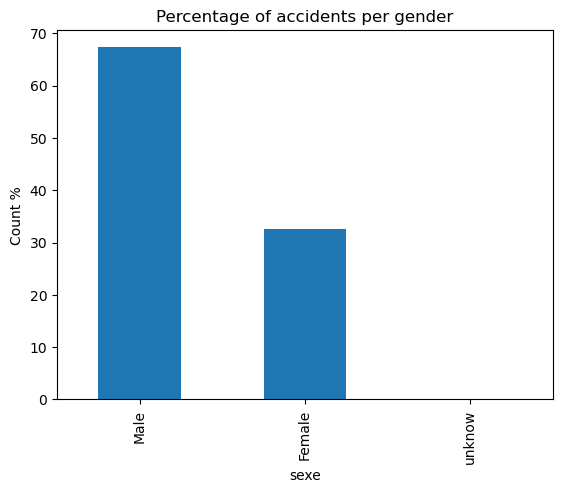

In [24]:
#number of accidents per gender

event_counts = df['sexe'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
event_percentages.plot.bar() 
labels = ['Male', 'Female', 'unknow']
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
#plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Percentage of accidents per gender')

plt.show()


## Filtering
### Drop non-metropolitan departments
It was decided to use only accidents in metropolitan France and Corse.

In preprocessing, the varible `metropolitan` with values `[0,1]` was created.

Now, the data is fitered by this variable and then it is dropped.

In [25]:
df = df.loc[df['metropolitan'] == 1]
df.drop('metropolitan', inplace=True, axis=1)

In [26]:
drop_columns = ['adr', 'lat', 'long']
df.drop(drop_columns, inplace = True, axis=1)

### Clean gravity
Gravity still contains data expressed by `-1` which is related to unknown injury. We need to remove this data.

In [27]:
unknown_count = (df['grav'] == -1).sum()

# Print the count
print(f"Number of data points with the value -1 in the 'grav' variable: {unknown_count}")

Number of data points with the value -1 in the 'grav' variable: 54


In [28]:
df = df[df['grav'] != -1]
df.isna().sum()

num_veh             0
place               0
catu                0
grav                0
sexe                0
an_nais             0
trajet              0
locp                0
actp                0
etatp               0
an                  0
mois                0
jour                0
hrmn                0
lum                 0
agg                 0
int                 0
atm                 0
col                 0
dep                 0
catr                0
circ                0
nbv                 0
vosp                0
prof                0
plan                0
surf                0
infra               0
situ                0
senc                0
catv                0
occutc              0
obs                 0
obsm                0
choc                0
manv                0
date                0
is_holiday          0
holiday       2367768
datetime            0
dtype: int64

### Encoding
For the first trial, use the `LabelEncoder` to encode categorial values. Then drop the old categorial values and replace them by the encoded.

In [29]:
# Encoding with LabelEncoder
encode_columns = ['actp', 'num_veh', 'etatp']
encoded_df = df[encode_columns]
encoded_df = encoded_df.astype('str')
encoded_df = encoded_df.apply(LabelEncoder().fit_transform)

# Merge encoded values
df.drop(encode_columns, inplace=True, axis=1)
df = pd.concat([df, encoded_df], axis=1)


<Figure size 1500x600 with 0 Axes>

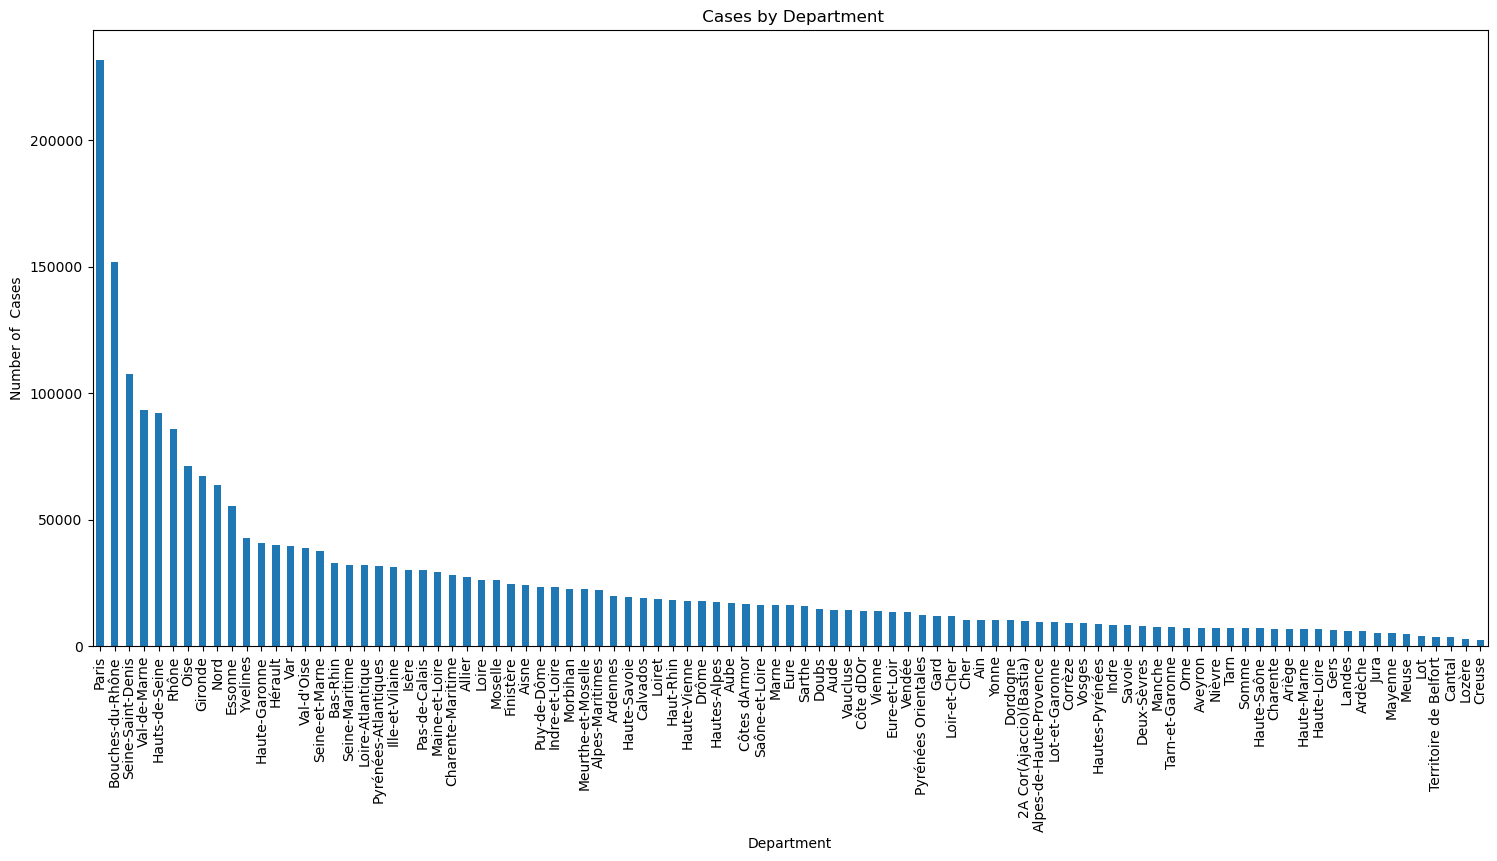

In [30]:
# number of accidents per department 

department_mapping = {
    'Ain': 1, 'Aisne': 2, 'Allier': 3, 'Alpes-de-Haute-Provence': 4, 'Hautes-Alpes': 5,
    'Alpes-Maritimes': 6, 'Ardèche': 7, 'Ardennes': 8, 'Ariège': 9, 'Aube': 10,
    'Aude': 11, 'Aveyron': 12, 'Bouches-du-Rhône': 13, 'Calvados': 14, 'Cantal': 15,
    'Charente': 16, 'Charente-Maritime': 17, 'Cher': 18, 'Corrèze': 19,
    '2A Cor(Ajaccio)(Bastia)': 20, 'Côte dDOr': 21,
    'Côtes dArmor': 22, 'Creuse': 23, 'Dordogne': 24, 'Doubs': 25, 'Drôme': 26,
    'Eure': 27, 'Eure-et-Loir': 28, 'Finistère': 29, 'Gard': 30, 'Haute-Garonne': 31,
    'Gers': 32, 'Gironde': 33, 'Hérault': 34, 'Ille-et-Vilaine': 35, 'Indre': 36,
    'Indre-et-Loire': 37, 'Isère': 38, 'Jura': 39, ' Landes': 40, 'Loir-et-Cher': 41,
    'Loire': 42, 'Haute-Loire': 43, 'Loire-Atlantique': 44, 'Loiret': 45, 'Lot': 46,
    'Lot-et-Garonne': 47, 'Lozère': 48, 'Maine-et-Loire': 49, 'Manche': 50, 'Marne': 51,
    'Haute-Marne': 52, 'Mayenne': 53, 'Moselle': 54, 'Meuse': 55, 'Morbihan': 56,
    'Meurthe-et-Moselle': 57, 'Nièvre': 58, 'Nord': 59, 'Oise': 60, 'Orne': 61,
    'Pas-de-Calais': 62, 'Puy-de-Dôme': 63, 'Pyrénées-Atlantiques': 64,
    'Hautes-Pyrénées': 65, 'Pyrénées Orientales': 66, 'Bas-Rhin': 67, 'Haut-Rhin': 68,
    'Rhône': 69, 'Haute-Saône': 70, 'Saône-et-Loire': 71, 'Sarthe': 72, 'Savoie': 73,
    'Haute-Savoie': 74, 'Paris': 75, 'Seine-Maritime': 76, 'Seine-et-Marne': 77,
    'Yvelines': 78, 'Deux-Sèvres': 79, 'Somme': 80, 'Tarn': 81, 'Tarn-et-Garonne': 82,
    'Var': 83, 'Vaucluse': 84, 'Vendée': 85, 'Vienne': 86, 'Haute-Vienne': 87,
    'Vosges': 88, 'Yonne': 89, 'Territoire de Belfort': 90, 'Essonne': 91,
    'Hauts-de-Seine': 92, 'Seine-Saint-Denis': 93, 'Val-de-Marne': 94, 'Val-d\'Oise': 95
}
# Reverse the department_mapping dictionary to map department numbers to names
department_mapping_reverse = {v: k for k, v in department_mapping.items()}


plt.figure(figsize=(15,6))
event_counts = df['dep'].value_counts()
acci_departments = event_counts.sort_values(ascending=False)

# Map department codes to department names for the x-axis labels
mapped_labels = [department_mapping_reverse.get(dep_code, dep_code) for dep_code in acci_departments.index]

# Plot the severity distribution
plt.figure(figsize=(18, 8))
ax = acci_departments.plot(kind='bar')
ax.set_xlabel('Department')
ax.set_ylabel('Number of  Cases')
ax.set_title(' Cases by Department')
ax.set_xticks(range(len(mapped_labels)))
ax.set_xticklabels(mapped_labels, rotation=90)



# Display the plot
plt.show();


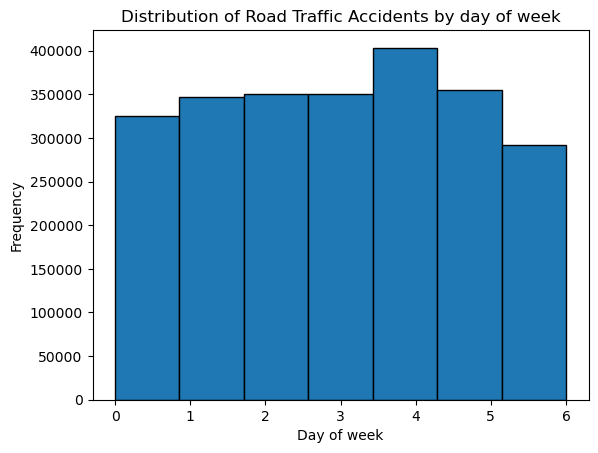

In [31]:
# Convert the 'datetime' column to a datetime data type
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the weekday from the 'datetime' column
df['day_of_week'] = df['datetime'].dt.weekday

# Plot the distribution of road traffic accidents by the hour of the day
df['day_of_week'].plot(kind='hist', bins=7, edgecolor='k')
plt.xlabel('Day of week')
plt.ylabel('Frequency')
plt.title('Distribution of Road Traffic Accidents by day of week')
plt.show()

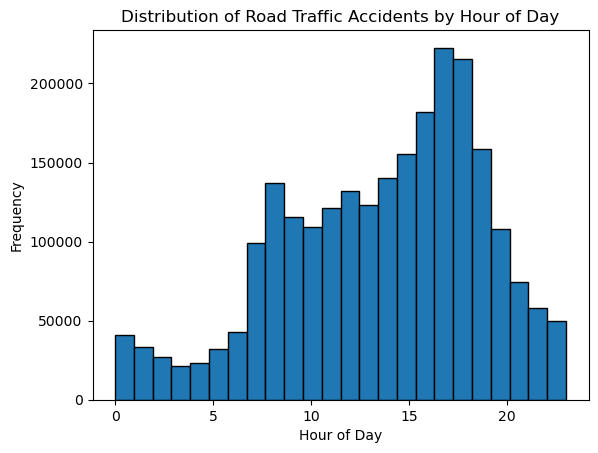

In [32]:
# Convert the 'datetime' column to a datetime data type
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the hour of the day from the 'datetime' column
df['hour_of_day'] = df['datetime'].dt.hour

# Plot the distribution of road traffic accidents by the hour of the day
df['hour_of_day'].plot(kind='hist', bins=24, edgecolor='k')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Distribution of Road Traffic Accidents by Hour of Day')
plt.show()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 42 columns):
 #   Column       Dtype         
---  ------       -----         
 0   place        float64       
 1   catu         int64         
 2   grav         int64         
 3   sexe         int64         
 4   an_nais      int64         
 5   trajet       float64       
 6   locp         float64       
 7   an           int64         
 8   mois         int64         
 9   jour         int64         
 10  hrmn         object        
 11  lum          int64         
 12  agg          int64         
 13  int          int64         
 14  atm          float64       
 15  col          float64       
 16  dep          int64         
 17  catr         float64       
 18  circ         float64       
 19  nbv          float64       
 20  vosp         float64       
 21  prof         float64       
 22  plan         float64       
 23  surf         float64       
 24  infra        

In [34]:
df.to_csv("./data/231030_clean_table_for_analysis.csv", sep = ',', header = True, na_rep = 'n/a', index=True)